In [2]:
import pickle
import glob
import swifter
import pandas as pd
import numpy as np
import random
import tensorflow_data_validation as tfdv
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'

In [3]:
import sys
sys.path.append('./../heart-failure-detection')

In [4]:
from utilities.preprocessing import AddTimeDifference, FilterTimeDiffs, MedianChannelsToList, Preprocess, \
    NormalizeChannels, AddBinaryClass, LogNormalizeBNP, LeadsToList, FilterDuplicatePatients

from utilities.constants import CHANNELS, MEDIAN_CHANNELS

In [5]:
files = glob.glob('./../data/*sec*.parquet')

In [7]:
%%time
df = [pd.read_parquet(file) for file in files]

CPU times: user 56.5 s, sys: 1min 10s, total: 2min 7s
Wall time: 8min 45s


In [1]:
# df.head()

In [8]:
# df.describe()

- Min Age is 0.010959 i.e. 4 days 
- Min BNP is 5, Max BNP is 70000
- Initially, get 1 record per patient

#### Preprocess - Log, Filter, Normalize

In [9]:
preprocess = Preprocess([
    FilterDuplicatePatients(),
    LogNormalizeBNP(),
    AddTimeDifference(),
    FilterTimeDiffs(time=120),
    LeadsToList(),
    NormalizeChannels(),
    AddBinaryClass(),
])

In [10]:
df = [preprocess(i) for i in df]

Pandas Apply:   0%|          | 0/5335 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5335 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5706 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5706 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4342 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4342 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6937 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6937 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4363 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/4363 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6894 [00:01<?, ?it/s]

Pandas Apply:   0%|          | 0/6894 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5759 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5759 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5559 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5559 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7501 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/7501 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5292 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/5292 [00:00<?, ?it/s]

In [49]:
df_ = pd.concat(df, ignore_index=True)

In [59]:
df_.to_parquet('./../data/ECG_BNP_10sec_hashed_combined.parquet', index=False)

In [40]:
# df_stats = tfdv.generate_statistics_from_dataframe(df)
# tfdv.visualize_statistics(df_stats)

#### Load Test PIDs

In [14]:
with open('./../data/Test_set_PID.pkl', 'rb') as f:
    test_pids = pickle.load(f)

In [15]:
# df_test = df[df.PID.isin(test_pids)]
# df_train = df[~(df.PID.isin(test_pids))]

#### Plot ECG

In [21]:
def plot_ecg(df, index):
    leads = df.loc[index][CHANNELS]
    bnp = df.loc[index]['BNP']
    leads_index = leads.index
    leads = leads.values.tolist()
    leads = [list(lead) for lead in leads]
    fig, ax = plt.subplots(12, 1, figsize=(15, 25), sharex=True)
    for i, (lead, channel) in enumerate(zip(leads, CHANNELS)):
        ax[i].plot(lead)
        ax[i].set_title(channel)
        ax[i].grid()
        
    fig.text(0.5, 0.04, f"BNP value for this patient is: {bnp}")
    
    

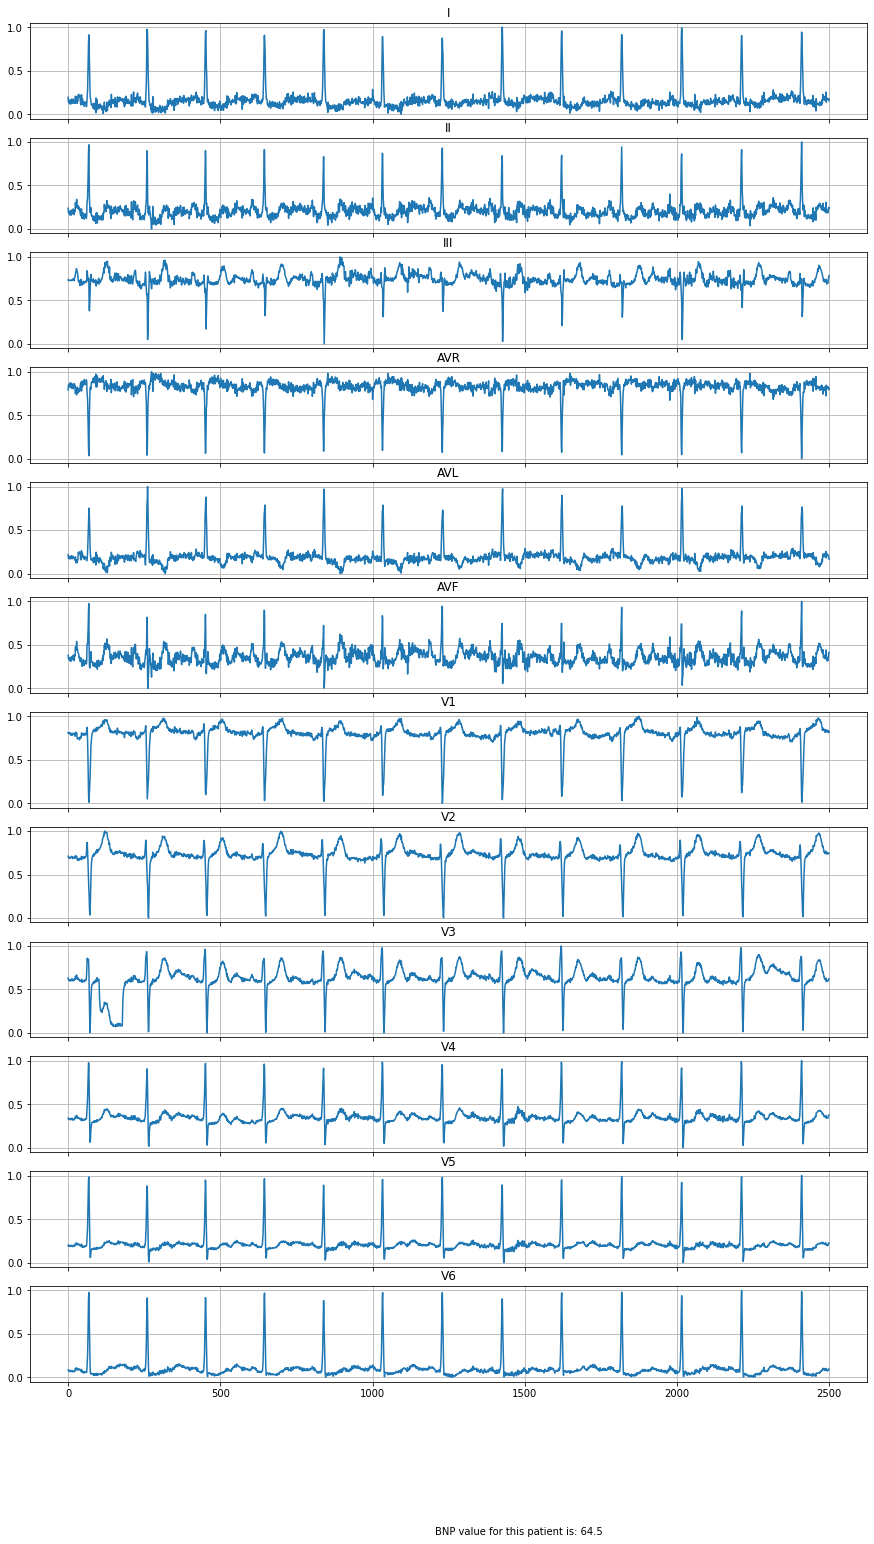

In [57]:
index = np.random.choice(np.array(df_.index))
plot_ecg(df_, index)

#### ECG containing empty leads

In [149]:
failed_rows = {channel: [] for channel in CHANNELS}
for index, row in df[CHANNELS].iterrows():
    for channel in CHANNELS:
        if all(v == 0 for v in row[channel]):
            failed_rows[channel].append(index)

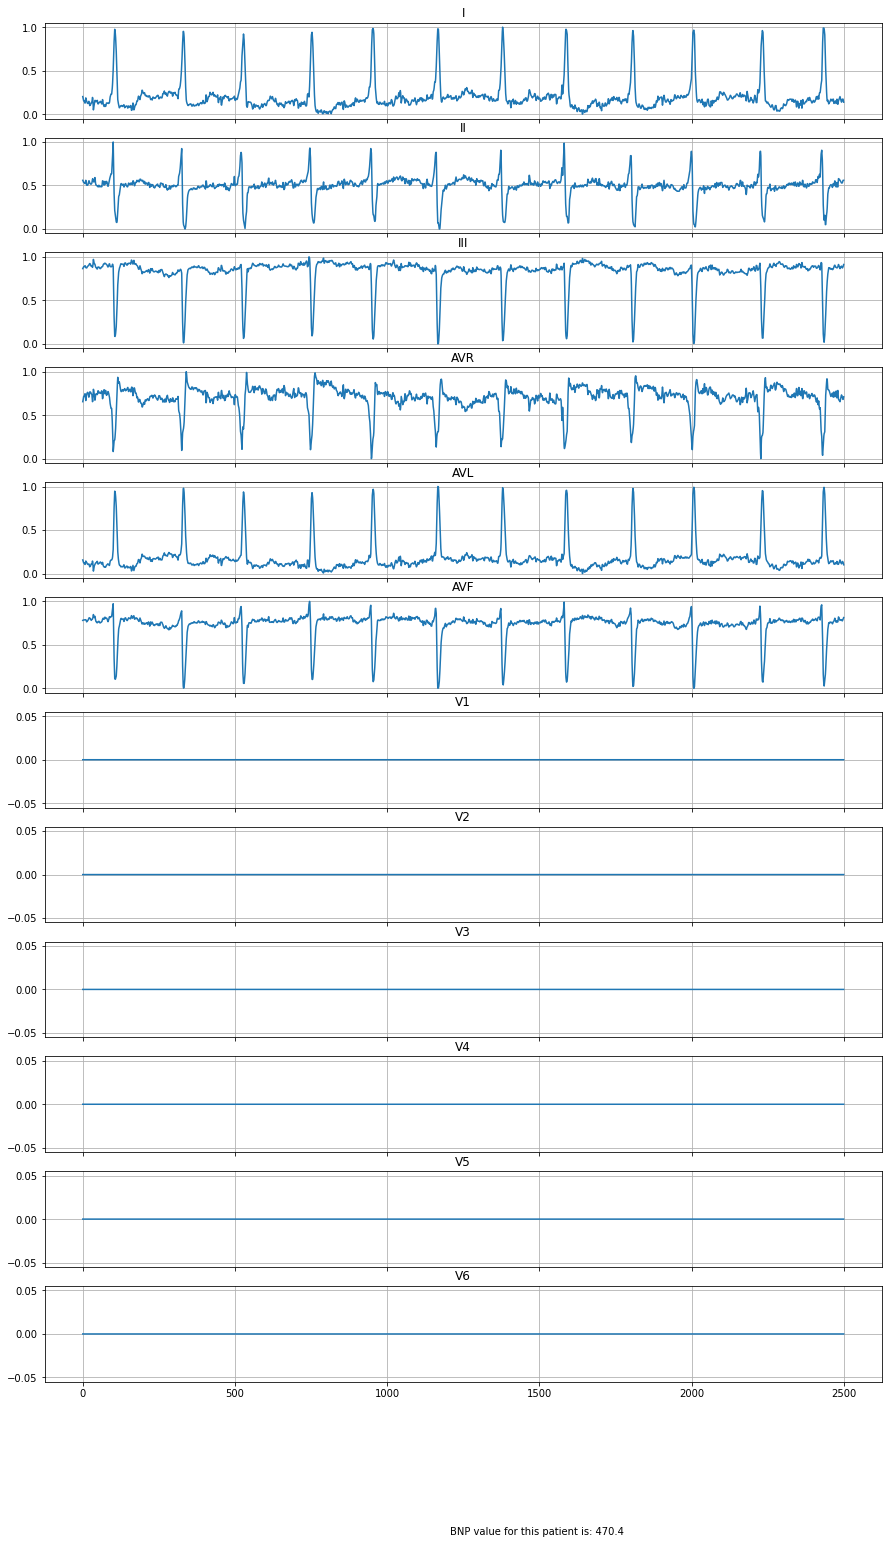

In [152]:
plot_ecg(df, 6887)

#### Check for duplicate records

In [161]:
df[df.duplicated(subset=['PID', 'BNP'], keep=False)]

,PID,Age,Gender,ECG_date_time,Blood_date_time,BNP,log_bnp,log_normalized_bnp,time_difference,I,...,AVR,AVL,AVF,V1,V2,V3,V4,V5,V6,class
2172,0677f8f894e444a6a902d922728aa35b,69.890411,FEMALE,01-03-2019 09:34:33,01-01-2019 13:53,17109.0,9.747360,0.852423,1.820521,"[0.5888888888888889, 0.5888888888888889, 0.577...",...,"[0.7272727272727273, 0.71900826446281, 0.72727...","[0.7638190954773869, 0.7537688442211056, 0.748...","[0.16326530612244897, 0.17346938775510204, 0.1...","[0.5454545454545454, 0.5606060606060606, 0.545...","[0.8739130434782608, 0.8739130434782608, 0.878...","[0.6923076923076923, 0.6923076923076923, 0.681...","[0.38934426229508196, 0.39344262295081966, 0.3...","[0.24102564102564103, 0.24102564102564103, 0.2...","[0.16149068322981366, 0.16149068322981366, 0.1...",True
2173,0677f8f894e444a6a902d922728aa35b,69.893151,FEMALE,01-04-2019 08:19:15,01-01-2019 13:53,17109.0,9.747360,0.852423,2.768229,"[0.6136363636363636, 0.6363636363636364, 0.613...",...,"[0.6359223300970874, 0.6213592233009708, 0.645...","[0.78125, 0.8, 0.79375, 0.78125, 0.8, 0.80625,...","[0.2727272727272727, 0.2727272727272727, 0.260...","[0.38095238095238093, 0.4021164021164021, 0.39...","[0.6342281879194631, 0.6342281879194631, 0.634...","[1.0, 0.9685314685314685, 0.9493006993006993, ...","[0.7266514806378133, 0.7289293849658315, 0.731...","[0.483739837398374, 0.483739837398374, 0.48373...","[0.3313253012048193, 0.3192771084337349, 0.319...",True
2174,0677f8f894e444a6a902d922728aa35b,69.879452,FEMALE,12-30-2018 09:36:33,01-01-2019 13:53,17109.0,9.747360,0.852423,-2.178090,"[0.6166666666666667, 0.55, 0.6166666666666667,...",...,"[0.5848214285714286, 0.6071428571428571, 0.580...","[0.5507246376811594, 0.5, 0.5434782608695652, ...","[0.3805031446540881, 0.3867924528301887, 0.386...","[0.5327102803738317, 0.4953271028037383, 0.514...","[0.7477477477477478, 0.7387387387387387, 0.738...","[0.92, 0.895, 0.885, 0.885, 0.885, 0.875, 0.86...","[0.9761904761904762, 0.9666666666666667, 0.904...","[0.6964285714285714, 0.6964285714285714, 0.633...","[0.42441860465116277, 0.42441860465116277, 0.4...",True
2175,0677f8f894e444a6a902d922728aa35b,69.879452,FEMALE,12-30-2018 11:58:17,01-01-2019 13:53,17109.0,9.747360,0.852423,-2.079664,"[0.3956043956043956, 0.3956043956043956, 0.373...",...,"[0.7191011235955056, 0.7191011235955056, 0.726...","[0.5747126436781609, 0.5747126436781609, 0.551...","[0.19805194805194806, 0.19805194805194806, 0.2...","[0.6697247706422018, 0.6880733944954128, 0.669...","[0.7863247863247863, 0.8290598290598291, 0.769...","[0.6782178217821783, 0.6782178217821783, 0.688...","[0.7767441860465116, 0.8511627906976744, 0.772...","[0.6577777777777778, 0.7733333333333333, 0.644...","[0.24519230769230768, 0.28365384615384615, 0.2...",True
2176,0677f8f894e444a6a902d922728aa35b,69.879452,FEMALE,12-30-2018 11:58:17,01-01-2019 13:53,17109.0,9.747360,0.852423,-2.079664,"[0.3956043956043956, 0.3956043956043956, 0.373...",...,"[0.7191011235955056, 0.7191011235955056, 0.726...","[0.5747126436781609, 0.5747126436781609, 0.551...","[0.19805194805194806, 0.19805194805194806, 0.2...","[0.6697247706422018, 0.6880733944954128, 0.669...","[0.7863247863247863, 0.8290598290598291, 0.769...","[0.6782178217821783, 0.6782178217821783, 0.688...","[0.7767441860465116, 0.8511627906976744, 0.772...","[0.6577777777777778, 0.7733333333333333, 0.644...","[0.24519230769230768, 0.28365384615384615, 0.2...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14538,87687059fab177bbb41958b6c99d9ee9,75.671347,MALE,03-14-2019 10:16:10,08-04-2019 08:00,1571.0,7.359468,0.602298,-24.905440,"[0.21804511278195488, 0.22556390977443608, 0.2...",...,"[0.7258883248730964, 0.7208121827411168, 0.725...","[0.15611814345991562, 0.16455696202531644, 0.1...","[0.645320197044335, 0.6403940886699507, 0.6305...","[0.8311111111111111, 0.8311111111111111, 0.831...","[0.8055555555555556, 0.8095238095238095, 0.811...","[0.7963302752293578, 0.8, 0.8036697247706422, ..."

#### Check for Abnormal BNP value

In [177]:
df.sort_values(by=['PID', 'ECG_date_time'])

,PID,Age,Gender,ECG_date_time,Blood_date_time,BNP,log_bnp,log_normalized_bnp,time_difference,I,...,AVR,AVL,AVF,V1,V2,V3,V4,V5,V6,class
6706,0030d0ffbb6be7c94a3c8a98e15d784f,86.358904,FEMALE,02-07-2019 11:58:01,07-02-2019 09:35,555.5,6.319869,0.493403,0.099317,"[0.39344262295081966, 0.41530054644808745, 0.4...",...,"[0.6777251184834123, 0.6753554502369669, 0.674...","[0.6457765667574932, 0.6548592188919165, 0.662...","[0.3359253499222395, 0.33177812337998963, 0.32...","[0.7232375979112271, 0.7232375979112271, 0.720...","[0.6634078212290503, 0.6662011173184358, 0.668...","[0.558599695585997, 0.5570776255707762, 0.5570...","[0.412962962962963, 0.412962962962963, 0.41111...","[0.23734177215189872, 0.23575949367088608, 0.2...","[0.32432432432432434, 0.32432432432432434, 0.3...",True
14313,0032947c2da8cfee0bc96be47f52fe19,73.082192,MALE,03-11-2019 21:46:02,11-03-2019 18:12,52.1,3.953165,0.245498,0.148634,"[0.14130434782608695, 0.14130434782608695, 0.1...",...,"[0.8276515151515151, 0.8257575757575758, 0.823...","[0.22704081632653061, 0.22448979591836735, 0.2...","[0.2334384858044164, 0.23974763406940064, 0.24...","[0.7467248908296943, 0.74235807860262, 0.73799...","[0.48639455782312924, 0.48299319727891155, 0.4...","[0.22615803814713897, 0.22615803814713897, 0.2...","[0.15772357723577235, 0.15609756097560976, 0.1...","[0.17102966841186737, 0.16753926701570682, 0.1...","[0.18202247191011237, 0.18202247191011237, 0.1...",False
6679,0058faa071b57a99d379d4ada749f91b,94.882192,FEMALE,02-13-2019 14:15:10,12-02-2019 20:15,1761.0,7.473637,0.614257,0.750116,"[0.8986486486486487, 0.956081081081081, 0.9189...",...,"[0.25426136363636365, 0.171875, 0.112215909090...","[0.8308457711442786, 0.8134328358208955, 0.626...","[0.4441489361702128, 0.5305851063829787, 0.686...","[0.26222222222222225, 0.23555555555555555, 0.1...","[0.35, 0.324, 0.188, 0.098, 0.188, 0.324, 0.42...","[0.7186788154897494, 0.7414578587699316, 0.711...","[0.8403441682600382, 0.8977055449330784, 0.917...","[0.8266666666666667, 0.8953846153846153, 0.934...","[0.7772988505747126, 0.8477011494252874, 0.913...",True
6680,0058faa071b57a99d379d4ada749f91b,94.884932,FEMALE,02-14-2019 05:21:08,12-02-2019 20:15,1761.0,7.473637,0.614257,1.379259,"[0.14606741573033707, 0.15168539325842698, 0.1...",...,"[0.7507163323782235, 0.7578796561604585, 0.765...","[0.37302977232924694, 0.38704028021015763, 0.4...","[0.41783649876135426, 0.4071015689512799, 0.39...","[0.7994428969359332, 0.7994428969359332, 0.799...","[0.7348837209302326, 0.7325581395348837, 0.730...","[0.6553911205073996, 0.6511627906976745, 0.646...","[0.6531165311653117, 0.6476964769647696, 0.642...","[0.4407252440725244, 0.43654114365411434, 0.43...","[0.17625899280575538, 0.16906474820143885, 0.1...",True
6681,0058faa071b57a99d379d4ada749f91b,94.884932,FEMALE,02-14-2019 10:51:22,12-02-2019 20:15,1761.0,7.473637,0.614257,1.608588,"[0.13333333333333333, 0.14583333333333334, 0.1...",...,"[0.7980456026058632, 0.7899022801302932, 0.786...","[0.3037974683544304, 0.310126582278481, 0.3212...","[0.5135658914728682, 0.5145348837209303, 0.509...","[0.6469387755102041, 0.6469387755102041, 0.651...","[0.6340852130325815, 0.6365914786967418, 0.640...","[0.6161473087818697, 0.6175637393767706, 0.621...","[0.45440956651718983, 0.45590433482810166, 0.4...","[0.25306748466257667, 0.254601226993865, 0.257...","[0.19223300970873786, 0.1941747572815534, 0.19...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10393,ffa0d66e55d8a6d50f4b49c5077fd49b,60.301370,MALE,03-05-2019 13:24:57,05-03-2019 11:10,561.3,6.330256,0.494491,0.093715,"[0.19642857142857142, 0.20238095238095238, 0.1...",...,"[0.8521400778210116, 0.8521400778210116, 0.863...","[0.34516129032258064, 0.3548387096774194, 0.33...","[0.4352517985611511, 0.4244604316546763, 0.435...","[0.8418604651162791, 0.8418604651162791, 0.841...","[0.8707482993197279, 0.8809523809523809, 0.870...","[0.7865497076023392, 0.7923976608187134, 0.771...","[0.887640449

#### Check for Abnormal lead value